In [1]:
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
import operator
from pydantic import BaseModel, Field
from IPython.display import display, Image, Markdown
from langgraph.constants import Send
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Annotated, List

In [2]:
class Section(BaseModel):
    """A section of a document."""
    title: str = Field(description="The title of the section.")
    content: str = Field(description="The content of the section.")
    
class Sections(BaseModel):
    """A document with sections."""
    sections: List[Section] = Field(description="The sections of the document.")
        
llm = ChatOllama(base_url="http://localhost:11434", model="qwen2.5:7b")
planner = llm.with_structured_output(Sections)

In [3]:
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str
        
        
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [10]:
# Nodes
def orchestrator(state: State):
    report_sections = planner.invoke([
        SystemMessage(content="根据研究主题生成研究计划。该计划每份的格式是一个json, json的内容包括title和content. 其中 title 是信息的标题, content 是信息的内容."),
        HumanMessage(content=f"我要研究的主题是: {state['topic']}")
    ])
    print(report_sections)
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """这是一个为根据报告生成Section的节点"""
    
    section = llm.invoke([
        SystemMessage(content="按照提供的计划标题与描述来撰写至少150字的研究报告，返回结果请使用 MarkDown 格式。"),
        HumanMessage(content=f'当前计划的标题是: {state['section'].title}, 计划的描述是: {state['section'].content}')
    ])
    
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    for s in state["sections"]:
        print("assign_workers", s, "\n")

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()


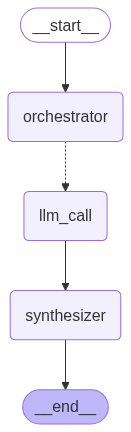

In [11]:
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [14]:
state = orchestrator_worker.invoke({"topic": "LLM Scaling Law"})

Markdown(state["final_report"])

ValidationError: 6 validation errors for Sections
sections.0
  Input should be a valid dictionary or instance of Section [type=model_type, input_value='引言', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
sections.1
  Input should be a valid dictionary or instance of Section [type=model_type, input_value='LLM的基本概念', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
sections.2
  Input should be a valid dictionary or instance of Section [type=model_type, input_value='已有工作回顾', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
sections.3
  Input should be a valid dictionary or instance of Section [type=model_type, input_value='方法与假设', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
sections.4
  Input should be a valid dictionary or instance of Section [type=model_type, input_value='数据收集与实验设计', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
sections.5
  Input should be a valid dictionary or instance of Section [type=model_type, input_value='预期结果与意义', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type